**Learninspy**
============
<img style="display: inline;" src="img/Learninspy-logo_grande.png" width="300" />

*Deep Learning in Spark, with Python*


"""Ejemplos de uso para entrenar redes neuronales con Learninspy utilizando datos de Iris (clasificación)."""

### Dependencias

In [1]:
import os
import logging
reload(logging)  # Jupyter bug (duplicated logging output)

from learninspy.core.model import NeuralNetwork, NetworkParameters
from learninspy.core.optimization import OptimizerParameters
from learninspy.core.stops import criterion
from learninspy.utils.data import LocalLabeledDataSet, load_iris
from learninspy.utils.evaluation import ClassificationMetrics
from learninspy.utils.plots import plot_fitting, plot_confusion_matrix
from learninspy.utils.fileio import get_logger

logger = get_logger(name='learninspy-ejemplo_iris')

%matplotlib inline

2017-03-04 19:29:38,181 - learninspy.context - INFO - Contexto de Spark inicializado.


<h2><center> #-- 1) Carga de datos --# </center></h2>

In [2]:
logger.info("Cargando datos de Iris ...")
dataset = load_iris()
dataset = LocalLabeledDataSet(dataset)
rows, cols = dataset.shape
logger.info("Dimension de datos: %i x %i", rows, cols)

train, valid, test = dataset.split_data([0.7, 0.1, 0.2])  # Particiono en conjuntos

2017-03-04 19:29:54,583 - learninspy-ejemplo_iris - INFO - Cargando datos de Iris ...
2017-03-04 19:29:54,599 - learninspy-ejemplo_iris - INFO - Dimension de datos: 150 x 4


In [3]:
train.data[:10]

[LabeledPoint(0.0, [5.0,3.5,1.3,0.3]),
 LabeledPoint(1.0, [6.7,3.1,4.4,1.4]),
 LabeledPoint(2.0, [6.2,3.4,5.4,2.3]),
 LabeledPoint(0.0, [4.4,2.9,1.4,0.2]),
 LabeledPoint(1.0, [5.6,3.0,4.1,1.3]),
 LabeledPoint(1.0, [6.3,2.5,4.9,1.5]),
 LabeledPoint(2.0, [6.0,2.2,5.0,1.5]),
 LabeledPoint(1.0, [5.8,2.6,4.0,1.2]),
 LabeledPoint(2.0, [6.7,3.1,5.6,2.4]),
 LabeledPoint(2.0, [7.7,3.0,6.1,2.3])]

<h2><center> #-- 2) Configuración y diseño --# </center></h2>

In [4]:
# 2.a) Parámetros de red neuronal
net_params = NetworkParameters(units_layers=[4, 10, 3], dropout_ratios=[0.0, 0.0],
                               activation=['ReLU', 'Softplus'], strength_l1=1e-5, strength_l2=3e-4,
                               classification=True, seed=123)

# 2.b) Parámetros de optimización
local_stops = [criterion['MaxIterations'](10),
               criterion['AchieveTolerance'](0.95, key='hits')]

global_stops = [criterion['MaxIterations'](20),
                criterion['AchieveTolerance'](0.95, key='hits')]

options = {'step-rate': 1.0, 'decay': 0.99, 'momentum': 0.7, 'offset': 1e-8}

optimizer_params = OptimizerParameters(algorithm='Adadelta', stops=local_stops, options=options,
                                       merge_criter='w_avg', merge_goal='cost')

logger.info("Optimizacion utilizada: %s", os.linesep+str(optimizer_params))
logger.info("Configuracion usada: %s", os.linesep+str(net_params))

2017-03-04 19:31:44,365 - learninspy-ejemplo_iris - INFO - Optimizacion utilizada: 
The algorithm used is Adadelta with the next parameters:
offset: 1e-08
step-rate: 1.0
momentum: 0.7
decay: 0.99
The stop criteria used for optimization is: 
Stop at a maximum of 10 iterations.
Stop when a tolerance of 0.95 is achieved/exceeded in hits.

2017-03-04 19:31:44,366 - learninspy-ejemplo_iris - INFO - Configuracion usada: 
Layer 0 with 4 neurons connects to Layer 1 having 10 neurons using ReLU activation and 0.0 ratio of DropOut.
Layer 1 with 10 neurons connects to Layer 2 having 3 neurons using Softmax activation.
The loss is CrossEntropy for a classification task.
L1 strength is 1e-05 and L2 strength is 0.0003.



<h2><center> #-- 3) Construcción y ajuste de red neuronal --# </center></h2>

In [5]:
neural_net = NeuralNetwork(net_params)

logger.info("Entrenando red neuronal ...")
hits_valid = neural_net.fit(train, valid, valid_iters=1, mini_batch=10, parallelism=4, stops=global_stops,
                            optimizer_params=optimizer_params, keep_best=True, measure='F-measure', reproducible=True)

2017-03-04 19:31:54,347 - learninspy-ejemplo_iris - INFO - Entrenando red neuronal ...
2017-03-04 19:32:02,495 - learninspy.core.model - INFO - Epoca 1 realizada en   7.8218s. Hits en train: 0.46780303030. Hits en valid: 0.46666666667
2017-03-04 19:32:03,142 - learninspy.core.model - INFO - Epoca 2 realizada en   0.6115s. Hits en train: 0.85402632840. Hits en valid: 0.70654310587
2017-03-04 19:32:03,591 - learninspy.core.model - INFO - Epoca 3 realizada en   0.4229s. Hits en train: 0.85294987169. Hits en valid: 0.70654310587
2017-03-04 19:32:04,057 - learninspy.core.model - INFO - Epoca 4 realizada en   0.4347s. Hits en train: 0.86449281854. Hits en valid: 0.79047619048
2017-03-04 19:32:04,490 - learninspy.core.model - INFO - Epoca 5 realizada en   0.4065s. Hits en train: 0.84181310718. Hits en valid: 0.70654310587
2017-03-04 19:32:04,957 - learninspy.core.model - INFO - Epoca 6 realizada en   0.4406s. Hits en train: 0.86088989814. Hits en valid: 0.77142857143
2017-03-04 19:32:05,345 -

<h2><center> #-- 4) Presentación de resultados --# </center></h2>

In [6]:
acc_test, predict = neural_net.evaluate(test, predictions=True, measure='Accuracy')

# Información de la clasificación
logger.info("Metricas de evaluación en clasificacion: ")
labels = map(lambda lp: float(lp.label), test.collect())
metrics = ClassificationMetrics(zip(predict, labels), 3)
logger.info("Accuracy: %12.11f", metrics.accuracy())
logger.info("F1-Score: %12.11f", metrics.f_measure(beta=1))
logger.info("Precision: %12.11f", metrics.precision())
logger.info("Recall: %12.11f", metrics.recall())
#logger.info("Matriz de confusion: %s", os.linesep+str(metrics.confusion_matrix()))

2017-03-04 19:32:59,214 - learninspy-ejemplo_iris - INFO - Metricas de evaluación en clasificacion: 
2017-03-04 19:32:59,216 - learninspy-ejemplo_iris - INFO - Accuracy: 1.00000000000
2017-03-04 19:32:59,217 - learninspy-ejemplo_iris - INFO - F1-Score: 1.00000000000
2017-03-04 19:32:59,218 - learninspy-ejemplo_iris - INFO - Precision: 1.00000000000
2017-03-04 19:32:59,219 - learninspy-ejemplo_iris - INFO - Recall: 1.00000000000


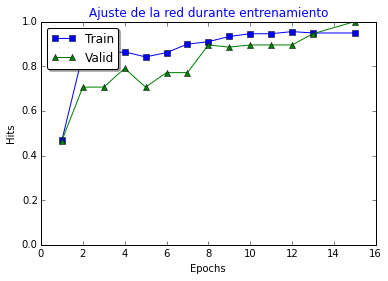

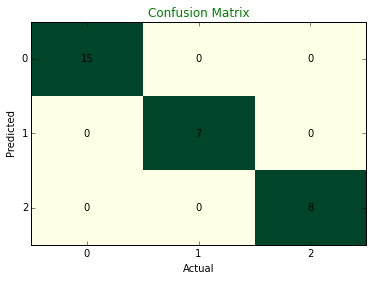

In [7]:
# Ploteo del ajuste de la red
plot_fitting(neural_net)

# Matriz de confusión
plot_confusion_matrix(metrics.confusion_matrix(), show=True)

In [8]:
# Guardar modelo en formato binario
neural_net.save(filename='/tmp/ejemplo_iris.lea')

print "Modelo NeuralNetwork:"
print str(neural_net.params)
print "Optimización:"
print str(optimizer_params)

Modelo NeuralNetwork:
Layer 0 with 4 neurons connects to Layer 1 having 10 neurons using ReLU activation and 0.0 ratio of DropOut.
Layer 1 with 10 neurons connects to Layer 2 having 3 neurons using Softmax activation.
The loss is CrossEntropy for a classification task.
L1 strength is 1e-05 and L2 strength is 0.0003.

Optimización:
The algorithm used is Adadelta with the next parameters:
offset: 1e-08
step-rate: 1.0
momentum: 0.7
decay: 0.99
The stop criteria used for optimization is: 
Stop at a maximum of 10 iterations.
Stop when a tolerance of 0.95 is achieved/exceeded in hits.

